## NFL In-Game Win Probability Model

The likehood that a possession team win will eventually win the game can be expressed as

$$ p(W_g| score_{g,t} ) = \frac{p(g_g| SX_{g,t} ) p(W_g)}{ p(SX_{g,t} | W_g) p(W_g) +  p(SX_{g,t} | \overline{W_g}) p( \overline{W_g}) } $$

where the subscript $g$ denotes the game and $t$ denotes minutes remaining in regualtion time. The following terms denote:

* $p(W_g| SX_{g,t})$: the posterior probability of that the possession team wins the $g^th$ game with $t$ minutes remaining 
* $p(W_g$: the prior probability of a possession team win
* $p(SX_{g,t} |W_g)$ and $p(SX_{g,t}  | \overline{W_g})$: inverse conditional probabilities

In [ ]:
import sys
import os
import pandas
import numpy
import datetime, time

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from pylab import hist, show
import scipy
import statsmodels.api as sm

pandas.set_option("display.max_rows", 35)
pandas.set_option("display.max_columns", 50)
pandas.set_option("display.max_colwidth", 200)

In [ ]:
DM = pandas.read_csv('NFL_plays_2013.csv')
DM.head()

In [ ]:
DM.describe()

In [ ]:
dt = DM.copy()

dt = dt.dropna(how='any')
dt = dt[dt.qtr<=4]

dt = dt.rename(columns={'min': 'minrem'})
dt['minstart'] = 60 - dt['minrem'] 
dt = dt[dt.minrem!=0]

dt['lnminrem'] = numpy.log(dt['minrem'])

dt['date'] = dt.gameid.str.split('_', 1, expand=True)[0]
dt['game'] = pandas.factorize(dt.gameid)[0] + 1
dt['match'] = dt.gameid.str.split('_', 1, expand=True)[1]
dt['away'] = dt.match.str.split('@', 1, expand=True)[0]
dt['home'] = dt.match.str.split('@', 1, expand=True)[1]


dt = dt[['date', 'match', 'home', 'away',
         'season', 'game', 'qtr', 'minstart', 'minrem', 'lnminrem',
         'off', 'def', 'scorediff', 'down', 'ydline', 
         'teamwin']]

dt[['season', 'game', 'qtr', 'minstart', 'minrem', 'scorediff', 'down', 'ydline', ]] = dt[['season', 'game', 'qtr', 'minstart', 'minrem', 'scorediff', 'down', 'ydline']].astype('int')

dt = dt.sort_values(['season', 'game', 'minstart'], ascending=[0,1,1])
dt.head()

In [ ]:
dt.describe()

In [ ]:
dt['scorecat'] = (dt.scorediff/7).astype('int')
dt['scorecat'] = numpy.where(dt.scorecat>3, 3, dt.scorecat)
dt['scorecat'] = numpy.where(dt.scorecat<-3, -3, dt.scorecat)
dt.scorecat.value_counts(normalize=True).round(4)

## Create season-game-minute observations

In [ ]:
dm = dt.groupby(['season', 'game', 'minstart']).first()
dm.head()

## Create conditional data frame

In [ ]:
d1 = dm[dm.teamwin==1]
d0 = dm[dm.teamwin==0]

### Summary analysis: mean inverse conditional plots

In [ ]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_notebook
output_notebook()

TOOLS = 'pan,wheel_zoom,box_zoom,reset,save,box_select'

y1 = d1.groupby('minstart')['scorediff'].mean()
y0 = d0.groupby('minstart')['scorediff'].mean()
x = range(0,61)


p1 = figure(title='Mean point differential throughout the progression of games.', 
            x_range=[0,60], y_range=[-10, 10], 
            x_axis_label = 'Minutes from game start', y_axis_label = 'Point differential', tools=TOOLS)

p1.line(x, y1, color='navy', alpha=1, line_width=3, legend='Possession team wins')
p1.line(x, y0, color='firebrick', alpha=1, line_width=3, legend='Possession team losses')
p1.ray([0], [0], color='black', length=300, angle=0, line_width=1)
p1.legend.location = 'bottom_left'
show(gridplot(p1, ncols=1, nrows=1, plot_width=800, plot_height=500))

### Estimate inverse conditional probabilities

In [ ]:
m1 = sm.MNLogit(d1.scorecat, sm.add_constant(d1.lnminrem)).fit()
m0 = sm.MNLogit(d0.scorecat, sm.add_constant(d0.lnminrem)).fit()

### MNL regression results: possession team wins

In [ ]:
m1.summary()

### MNL regression results: possession team losses

In [ ]:
m0.summary()

### Predicted Bayes Factors across score and time remaining states


In [23]:
b1 = pandas.DataFrame(m1.predict(sm.add_constant(dt.lnminrem)))
b0 = pandas.DataFrame(m0.predict(sm.add_constant(dt.lnminrem)))
bf = b1/b0

#change column names to be consistent with score states
bf.columns = bf.columns - 3

bf.head()

-3        -2        -1         0         1         2         3
1  0.312320  0.322768  0.552567  1.053379  2.045222  3.373898  4.615035
2  0.310995  0.321876  0.551006  1.054414  2.044829  3.371015  4.606048
3  0.309654  0.320974  0.549426  1.055474  2.044444  3.368108  4.596956
4  0.309654  0.320974  0.549426  1.055474  2.044444  3.368108  4.596956
5  0.309654  0.320974  0.549426  1.055474  2.044444  3.368108  4.596956

In [24]:
dr = pandas.merge(dt, bf, left_index=True,right_index=True)
dr.head()

date    match home away  season  game  qtr  minstart  minrem  lnminrem  \
1  20130905  BAL@DEN  DEN  BAL    2013     1    1         0      60  4.094345   
2  20130905  BAL@DEN  DEN  BAL    2013     1    1         1      59  4.077537   
3  20130905  BAL@DEN  DEN  BAL    2013     1    1         2      58  4.060443   
4  20130905  BAL@DEN  DEN  BAL    2013     1    1         2      58  4.060443   
5  20130905  BAL@DEN  DEN  BAL    2013     1    1         2      58  4.060443   

   off  def  scorediff  down  ydline  teamwin  scorecat        -3        -2  \
1  BAL  DEN          0     1      80        0         0  0.312320  0.322768   
2  BAL  DEN          0     2      81        0         0  0.310995  0.321876   
3  BAL  DEN          0     3      78        0         0  0.309654  0.320974   
4  BAL  DEN          0     4      72        0         0  0.309654  0.320974   
5  DEN  BAL          0     1      77        1         0  0.309654  0.320974   

         -1         0         1         2         3  
1  0.552567  1.053379  2.045222  3.373898  4.615035  
2  0.551006  1.054414  2.044829  3.371015  4.606048  
3  0.549426  1.055474  2.044444  3.368108  4.596956  
4  0.549426  1.055474  2.044444  3.368108  4.596956  
5  0.549426  1.055474  2.044444  3.368108  4.596956

In [25]:
dr['bf'] = 0
for s in [-3, -2, -1, 0, 1, 2, 3]:
    dr['bf'] = numpy.where(dr.scorecat==s, dr[s], dr.bf)
dr.head()

date    match home away  season  game  qtr  minstart  minrem  lnminrem  \
1  20130905  BAL@DEN  DEN  BAL    2013     1    1         0      60  4.094345   
2  20130905  BAL@DEN  DEN  BAL    2013     1    1         1      59  4.077537   
3  20130905  BAL@DEN  DEN  BAL    2013     1    1         2      58  4.060443   
4  20130905  BAL@DEN  DEN  BAL    2013     1    1         2      58  4.060443   
5  20130905  BAL@DEN  DEN  BAL    2013     1    1         2      58  4.060443   

   off  def  scorediff  down  ydline  teamwin  scorecat        -3        -2  \
1  BAL  DEN          0     1      80        0         0  0.312320  0.322768   
2  BAL  DEN          0     2      81        0         0  0.310995  0.321876   
3  BAL  DEN          0     3      78        0         0  0.309654  0.320974   
4  BAL  DEN          0     4      72        0         0  0.309654  0.320974   
5  DEN  BAL          0     1      77        1         0  0.309654  0.320974   

         -1         0         1         2         3        bf  
1  0.552567  1.053379  2.045222  3.373898  4.615035  1.053379  
2  0.551006  1.054414  2.044829  3.371015  4.606048  1.054414  
3  0.549426  1.055474  2.044444  3.368108  4.596956  1.055474  
4  0.549426  1.055474  2.044444  3.368108  4.596956  1.055474  
5  0.549426  1.055474  2.044444  3.368108  4.596956  1.055474

In [26]:
dr['priorprob'] = 0.5
dr['priorodds'] = 0.5 / (1 - dr.priorprob)


In [27]:
# # ## calculate posterior odds and probabilities (Bayes Rule)
dr['postodds'] =  dr['priorodds'] * dr['bf']
dr['postprob'] =  dr.postodds / (1 + dr.postodds)

dr['postprob_home'] = numpy.where(dr.home==dr.off, dr.postprob, 1-dr.postprob)
dr['scorediff_home'] = numpy.where(dr.home==dr.off, dr.scorediff, -1*dr.scorediff)

dr.head(10)

date    match home away  season  game  qtr  minstart  minrem  \
1   20130905  BAL@DEN  DEN  BAL    2013     1    1         0      60   
2   20130905  BAL@DEN  DEN  BAL    2013     1    1         1      59   
3   20130905  BAL@DEN  DEN  BAL    2013     1    1         2      58   
4   20130905  BAL@DEN  DEN  BAL    2013     1    1         2      58   
5   20130905  BAL@DEN  DEN  BAL    2013     1    1         2      58   
6   20130905  BAL@DEN  DEN  BAL    2013     1    1         2      58   
7   20130905  BAL@DEN  DEN  BAL    2013     1    1         3      57   
8   20130905  BAL@DEN  DEN  BAL    2013     1    1         3      57   
9   20130905  BAL@DEN  DEN  BAL    2013     1    1         4      56   
10  20130905  BAL@DEN  DEN  BAL    2013     1    1         4      56   

    lnminrem  off  def  scorediff  down  ydline  teamwin  scorecat        -3  \
1   4.094345  BAL  DEN          0     1      80        0         0  0.312320   
2   4.077537  BAL  DEN          0     2      81        0         0  0.310995   
3   4.060443  BAL  DEN          0     3      78        0         0  0.309654   
4   4.060443  BAL  DEN          0     4      72        0         0  0.309654   
5   4.060443  DEN  BAL          0     1      77        1         0  0.309654   
6   4.060443  DEN  BAL          0     2      77        1         0  0.309654   
7   4.043051  DEN  BAL          0     3      76        1         0  0.308299   
8   4.043051  DEN  BAL          0     1      66        1         0  0.308299   
9   4.025352  DEN  BAL          0     2      66        1         0  0.306927   
10  4.025352  DEN  BAL          0     3      59        1         0  0.306927   

          -2        -1         0         1         2         3        bf  \
1   0.322768  0.552567  1.053379  2.045222  3.373898  4.615035  1.053379   
2   0.321876  0.551006  1.054414  2.044829  3.371015  4.606048  1.054414   
3   0.320974  0.549426  1.055474  2.044444  3.368108  4.596956  1.055474   
4   0.320974  0.549426  1.055474  2.044444  3.368108  4.596956  1.055474   
5   0.320974  0.549426  1.055474  2.044444  3.368108  4.596956  1.055474   
6   0.320974  0.549426  1.055474  2.044444  3.368108  4.596956  1.055474   
7   0.320061  0.547827  1.056561  2.044067  3.365178  4.587759  1.056561   
8   0.320061  0.547827  1.056561  2.044067  3.365178  4.587759  1.056561   
9   0.319137  0.546209  1.057677  2.043699  3.362224  4.578451  1.057677   
10  0.319137  0.546209  1.057677  2.043699  3.362224  4.578451  1.057677   

    priorprob  priorodds  postodds  postprob  postprob_home  scorediff_home  
1         0.5        1.0  1.053379  0.512998       0.487002               0  
2         0.5        1.0  1.054414  0.513243       0.486757               0  
3         0.5        1.0  1.055474  0.513494       0.486506               0  
4         0.5        1.0  1.055474  0.513494       0.486506               0  
5         0.5        1.0  1.055474  0.513494       0.513494               0  
6         0.5        1.0  1.055474  0.513494       0.513494               0  
7         0.5        1.0  1.056561  0.513751       0.513751               0  
8         0.5        1.0  1.056561  0.513751       0.513751               0  
9         0.5        1.0  1.057677  0.514015       0.514015               0  
10        0.5        1.0  1.057677  0.514015       0.514015               0

In [28]:


games = dr.game.unique()[0]
dr['gamenumber'] = dr.game
dr['minStart'] = dr.minstart
dr['priorProb'] = dr.priorprob
dr['postProb'] = dr.postprob_home
dr['homeSM'] = dr.scorediff_home


d1 = dr[dr['game']==1]
print(len(d1))
d1[['game', 'minstart', 'scorediff_home', 'postprob_home' ]].head()


183


game  minstart  scorediff_home  postprob_home
1     1         0               0       0.487002
2     1         1               0       0.486757
3     1         2               0       0.486506
4     1         2               0       0.486506
5     1         2               0       0.513494

<IPython.core.display.Javascript object>


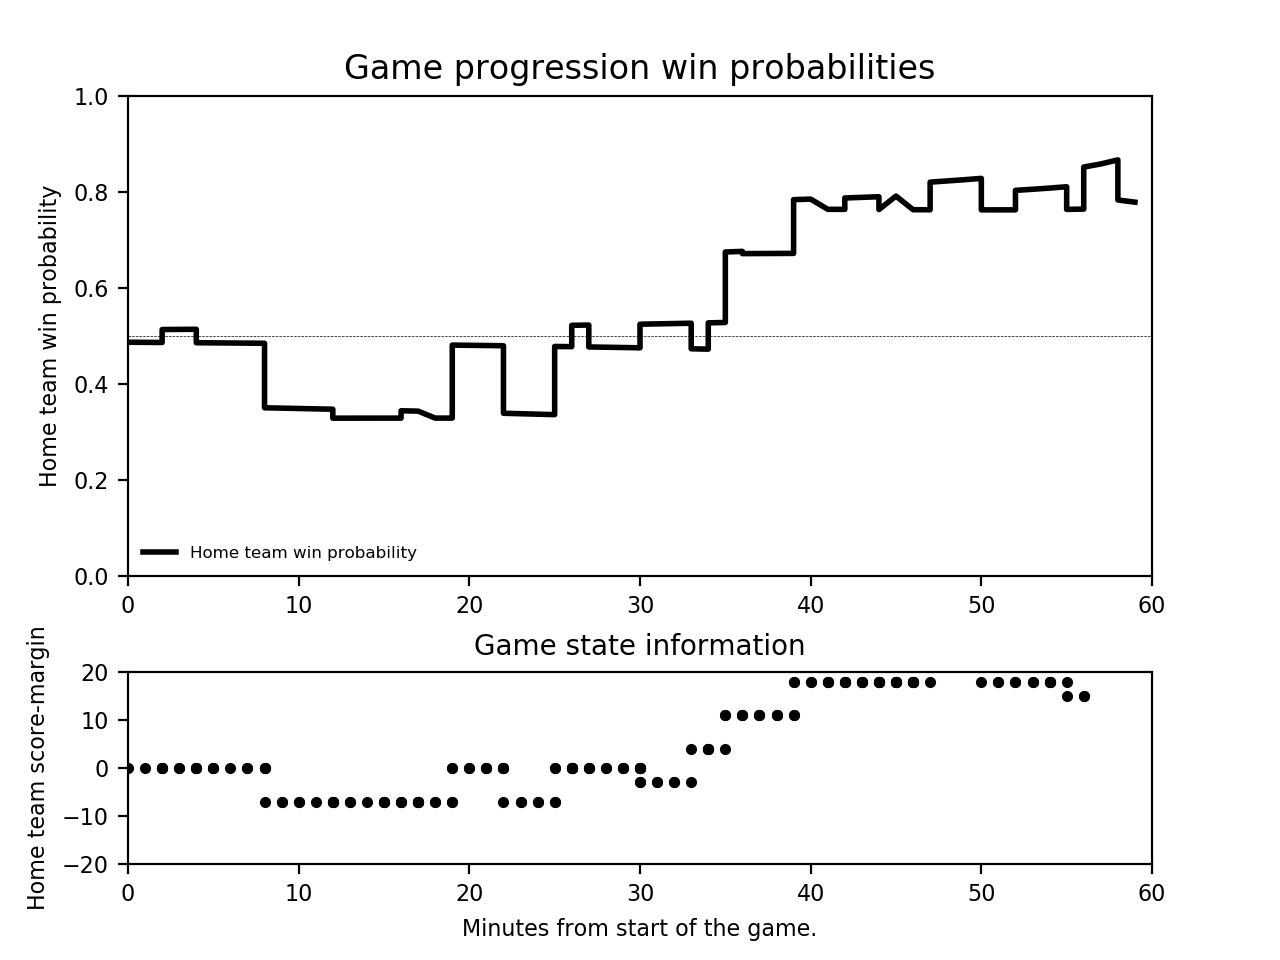

In [31]:
import matplotlib.pyplot as plt
%matplotlib notebook
# plot 
plt.rc('axes', grid=False)

width = 0.001
space = width + 0.10
left, width = 0.1, 0.8
rect1 = [left, 0.4, width, 0.5]
rect2 = [left, 0.1, width, 0.2]

fig = plt.figure(facecolor='white')
ax1 = fig.add_axes(rect1, facecolor='white')
ax2 = fig.add_axes(rect2, facecolor='white', sharex=ax1)

ax1.tick_params(axis='y', labelsize=8)
ax1.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.tick_params(axis='x', labelsize=8)
ax1.set_ylim([0,1])
ax2.set_ylim([-20,20])
ax1.set_xlim([0,60])

# ig.suptitle(gameTitle, fontsize=12)
ax1.set_title("Game progression win probabilities", fontsize=12)
ax1.set_ylabel('Home team win probability', fontsize=8)
ax2.set_title('Game state information', fontsize=10, multialignment='center')
ax2.set_ylabel('Home team score-margin', fontsize=8, multialignment='center')
ax2.set_xlabel('Minutes from start of the game.', fontsize=8)

# plot lines
ax1.plot(d1['minStart'], d1['postProb']  , marker='', linestyle='-' , linewidth=2, color='black',  label='Home team win probability')
ax1.axhline(y=.5 ,c="black",linewidth=0.25, linestyle='--', zorder=0)
ax2.plot(d1.minStart, d1.homeSM, '.', linewidth=0.5, color='black')

legend = ax1.legend(loc='lower left', shadow=False, fontsize=6, frameon=False)

# save figure
plt.savefig("gn500.pdf", format='pdf')
# plt.close('all')
plt.show()

# Done